# An Aspect Based Sentiment Analysis.

In my LDA topic model analysis of Tears of the Kingdom Reviews, I took a look at the different topics generated by running a topic model on negative, positive and mixed reviews. Those topics consisted of a selection of keywords which I then sumaries with blanket/umrella terms.  Here, I am going to be using an those very same keywords (as well as my own imagination and experience with the game) as aspects in "aspect based sentiment classifier" deep learning model. In this way I hope to obtain obtain a quantitative assessment of the sentiments toward each "aspects" of the game based on the reviews.

Let's a Go!

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
sns.set_style('darkgrid')
from ast import literal_eval

# Importing the huggingface transformers model:
This model is found here: https://huggingface.co/yangheng/deberta-v3-base-absa-v1.1
It is an aspect based sentiment classifier. We can use this to classify the sentiments of aspects inside a piece of text. There is an example in the code below.


In [2]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

model_name = "yangheng/deberta-v3-base-absa-v1.1"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=False)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

classifier = pipeline("text-classification", model=model, tokenizer=tokenizer)

for aspect in ['camera', 'phone']:
   print(aspect, classifier('The camera quality of this phone is amazing.',  text_pair=aspect))

camera [{'label': 'Positive', 'score': 0.9967294931411743}]
phone [{'label': 'Neutral', 'score': 0.947278618812561}]


<br>
As you can see the model classified the camera as having a positive sentiment and the phone with a neutral sentiment and from the sentence we can see this checks out. 

<br>
<br>

----





## Importing the Tears of the Kingdom User Reviews
We'll import the dataset containing the user reviews. This dataset is the one that has already been preprocessed in my notebook where I processed the All we need to do is to convert the review text into lower case. This is because we won't have to account for any case differences when matching aspects in the text.

In [3]:
totk_reviews = pd.read_csv('cleaned_totk_reviews.csv')


In [4]:
#Create a column containing the review text in lowercase.

totk_reviews['lowercase_reviews'] = totk_reviews.review_text.apply(lambda x: x.lower())

## Choosing Aspects
I'll use a mixture of my own knowledge to identify aspects as well as key words identified for the different topics in the LDA Topic Modelling analysis of these reviews done previously. Below is a selection of the topics fo each review category. 

Positive Review Topics

- graphic, bad, fps, performance, console, issue, problem, score, frame, little, fix, hardware, dlc, time, point.
- time, year, experience, absolutely, wait, finish, life, long, day, end , stop, spend, buy, gaming, worth
- world, story, mechanic, open, gameplay, beautiful, simply, explore, freedom, time, predecessor, previous, map, creativity, history
- gameplay, experience, world, adventure, character, challenge, series, design, narrative, truly, set, create, captivate, engage, moment
- weapon, fuse, time, hand ability, puzzle, item, combat, system, enemy, solve, build, allow, world, break
- map, story, sky, explore, dungeon boss, island, world, ability, depth, quest, underground, enemy, different, main

Negative Review Topics

- weapon, puzzle, item, build, shrine, break, time, dungeon, fight, enemy, mechanic, combat, fuse, building
- map, story, sky, repetitive, time, character, shrine, depth, interesting, main, island, quest, boss, place,
- bad, story, world, time, mechanic, graphic, previous, gameplay, experience, open, dlc, long, old, problem, system,
- map, fps, graphic, issue, price, low, critic, quality, hardware, score, developer, high, charge, face, poor

Negative/Mixed Review Topics

- sky, story, dungeon, map, island, shrine, time, big, boss, quest, depth, explore, interesting, main, ability
- gameplay, adventure, character, experience, completely, create, narrative, far, true, close, development expect, construction, addition, develop
- world, story, bad, mechanic, time, gameplay, open, previous, dlc, old, experience, build, problem, map, issue
- graphic, fps, console, performance, quality, price, hardware, low, poor, critic, level, choice, high, developer, score
- weapon, enemy, time, break, puzzle, item, shrine, combat, system, spend, fuse, grind, annoying, arrow, material


______

### Creating a set of aspects

We can use the absa model to quantitively evaluate the balance between positive and negative sentiments toward different aspects. For example 25% of sentiment toward the combat system could be negative, and 75% could be positive. 

First we will create a list of aspects from the topic key words and then afterward some will be sorted them under "umbrella aspects" and categories. The topic key words above are lemmatized so there are some words like "graphic" that in the documents wlll actually appear as "graphics".

Here is a list of aspects under umbrella terms:

Visual Presentation: "graphics", "visuals", "framerate", "fps", "frame rate". <br>

Combat : "combat", "weapons", "fuse", "weapons breaking", "weapon durability", "weapon breaking", "enemy", "enemy variety", "enemies", "boss", "bosses", "dungeon boss", "dungeon bosses", "mini-boss" "mini boss" "minibosses", "miniboss" "mini-bosses"
<br>

Story: "story", "plot", "narrative", "narratives", "character", "characters", "main quest", "main quests" <br>

Puzzles:  "puzzles", "puzzle", "shrines", "dungeons" <br>

Abilities: "abilities", "ability", "fuse", "ultrahand", "autobuild", "build", "building", "ascend", "recall", "mechanics" <br>
(Abilities are aggregated here but will be evaluated separately) <br>

Game World and Exploration: "world", "map", "maps", "exploration", "depths", "underground", "caves", "sky islands","sky island", "sky", "vehicles"<br>

Price: "price", "cost" <br>

User Interface : "menu", "interface", "user interface", "UI"

Side Quests:  "sidequest", "side quest", "side adventures", "side adventure"

Soundtrack:  "music", "soundtrack", "score"

Miscellaneous: "Quests", "quests", "gameplay", "mechanics"

Caves: "caves" and "cave"

Depths: "depths" and "underground" and "under ground"




- Below we can create a list of aspects
- To speed things up later, lets identify reviews that have at least on aspect within them and then filter for those in our analysis.

In [5]:
aspects = ["graphics", "visuals", "framerate", "fps", "frame rate",
           "combat", "weapons", "weapon system", "weapons system", "fuse", "weapons breaking", "weapon durability", "weapon breaking",
           "music", "soundtrack", "score",
           "narratives", "characters","story", "plot", "narrative", "storyline",
           
           "enemy", "enemy variety", "enemies", "boss", "bosses", "dungeon boss", 
           "dungeon bosses", "bossfight", "bossfights", "boss fight", "final boss",
           "mini-boss", "mini boss", "minibosses", "miniboss", "mini-bosses", "monster", "monsters", "monster variety", 
           
           "cave", "caves", "underground", "under ground","world", "map", "maps",
           "exploration", "depths", "sky islands", "sky", "sky island",
           "main quest","main quests",
           "puzzles", "puzzle", "shrines", "dungeons", "abilities",
           "ability", "ultrahand","ultra hand", "autobuild", "auto build", "building", "build", "ascend", "recall", 
           "vehicles", "price", "cost","quests","quest",
           "gameplay", "mechanics",
           "menu","ui", "interface", "user interface", 
           "sidequests", "side quests", "side adventures" ]




## Identifying and Classifying Aspects

#### Filtering out irrelevant reviews
We'll add a column of boolean values to the dataframe called "has_aspect" so we can filter out reviews that have no aspects from the list mentioned in their text.

In [ ]:
#Creates the column by checking for words in the aspect list using regex and str.contains method from pandas.
totk_reviews['has_aspect'] = totk_reviews.lowercase_reviews.str.contains(r'\b('+r'|'.join(word for word in aspects)+r')\b',regex=True)

In [7]:
#Create a new dataframe only containing reviews with identifiable aspects within their text
totk_reviews_wa = totk_reviews[totk_reviews['has_aspect']==True]

the "wa" is not a reference to "waluigi". 

It represents something deeper.

"with aspects"

In [8]:
del totk_reviews #We no longer need the original dataframe

#### Defining some useful functions:
We need 3 simple functions:
- One will take a list of aspects and create a dictionary with each aspect being a key and their values being a nested dictionary with key-value pairs of both sentiment and sentiment count
- We need a function that takes a list of aspects found within a review and then runs the classifier on the text for each aspect and then adding to the sentiment count in the dictionary we have created.
- We need a function that we can use to add a column to the dataframe that contains a list of aspects found within each review.

In [9]:
def counter_dictionary(keylist):
    #Give this function a list of keys and it will return a dictionary with a subdict containing a sentiment and value count
    
    output_dictionary = {}
    for k in keylist:
        output_dictionary.update({k:{'Positive':0,'Negative':0, 'Neutral':0}})
    return output_dictionary

def sentiment_classification_count(sentence, aspect_list,aspect_dict):

    #create a list of  known aspects found within the review text.
    sentence_aspects = list(set(re.findall(r'\b('+r'|'.join(word for word in aspect_list)+r')\b', sentence)))

    #for each aspect run the sentiment classifier adding a point to the respective aspect and sentiment to the aspect dictionary
    for aspect in sentence_aspects:
       classifier_output = classifier(sentence,  text_pair=aspect)
       if classifier_output[0]['label'] == 'Negative':
           aspect_dict[aspect]['Negative'] +=1
       elif classifier_output[0]['label'] == 'Positive':
           aspect_dict[aspect]['Positive'] +=1
       elif classifier_output[0]['label'] == 'Neutral':
           aspect_dict[aspect]['Neutral'] +=1
       else:
           pass
    return sentence_aspects #return the list of aspects at the end 


In [10]:
aspect_dict = counter_dictionary(aspects)

In [11]:

totk_reviews_wa['aspects_within'] = totk_reviews_wa.lowercase_reviews.apply(lambda x :sentiment_classification_count(x, aspects, aspect_dict))


#### Inspecting our dictionary:

In [12]:
aspect_dict

{'graphics': {'Positive': 192, 'Negative': 160, 'Neutral': 9},
 'visuals': {'Positive': 48, 'Negative': 12, 'Neutral': 0},
 'framerate': {'Positive': 14, 'Negative': 31, 'Neutral': 0},
 'fps': {'Positive': 59, 'Negative': 106, 'Neutral': 2},
 'frame rate': {'Positive': 21, 'Negative': 32, 'Neutral': 0},
 'combat': {'Positive': 164, 'Negative': 109, 'Neutral': 9},
 'weapons': {'Positive': 125, 'Negative': 138, 'Neutral': 29},
 'weapon system': {'Positive': 5, 'Negative': 9, 'Neutral': 1},
 'weapons system': {'Positive': 0, 'Negative': 0, 'Neutral': 0},
 'fuse': {'Positive': 113, 'Negative': 48, 'Neutral': 5},
 'weapons breaking': {'Positive': 0, 'Negative': 0, 'Neutral': 0},
 'weapon durability': {'Positive': 14, 'Negative': 26, 'Neutral': 4},
 'weapon breaking': {'Positive': 1, 'Negative': 8, 'Neutral': 1},
 'music': {'Positive': 174, 'Negative': 54, 'Neutral': 4},
 'soundtrack': {'Positive': 96, 'Negative': 15, 'Neutral': 0},
 'score': {'Positive': 62, 'Negative': 50, 'Neutral': 2},
 

#### Merging Aspects:
Many aspects identify the same thing. Below is a selection:
- "side quests" and "sidequests"
- "UI", "interface", "user interface", "menu".
- "price" and "cost"
- "sky", "sky islands" and "sky island"
- "abilities" and "ability"
- "plot" and "story", "narrative" and "narratives"
- "puzzles" and "puzzle"
- "cave and "caves"
- "autobuild" and "auto build"
- "map" "maps" and "world"
- "main quest" and "main quests"
- "framerate", "frame rate", "fps
- "building" and "build"
- "quest" and "quests
- "weapon durability", "weapon breaking", "weapons breaking"
- "ultrahand" and "ultra hand"
- all the variations of enemies and bosses monsters will be merged
- "music" and "soundtrack" and "score"
- "depths" "underground" "under ground"
- "weapons system" and "weapon system" merge with "weapon durability"


We can merge these under one name for easy analysis

In [68]:
#creating a copy of the dictionary thatwe can edit and create a dataframe out of
aspect_sentiment_counts = aspect_dict.copy()

In [69]:
# create some tuples with values of an umbrella term and list of words that fall under them
key_value_mergings = [('SideQuests',['side quests','sidequests']), 
                      ("User Interface",["ui","interface","user interface","menu"]),
                      ("Price",["price","cost"]), 
                      ("Sky",["sky islands","sky", "sky island"]), 
                      ("Ability",["abilities","ability"]),
                      ("Plot",["plot","story","narrative","narratives","storyline"]), 
                      ("Puzzles",["puzzles","puzzle"]),
                      ("AutoBuild",["autobuild","auto build", "auto build"]), 
                      ("World",["map","maps","world"]),
                      ('Framerate', ['fps','frame rate','framerate']), 
                      ("Main Quests",["main quests", "main quest"]),
                      ("Build", ["build", "building"] ), 
                      ("Quests", ["quests", "quest"]),
                      ("Weapon Durability", ["weapon breaking", "weapons breaking", "weapon durability", "weapon system", "weapons system"]),
                      ("Ultrahand", ["ultra hand", "ultrahand"]),
                      ("Enemies",['enemy', 'enemy variety', 'enemies', "monster", "monsters","monster variety"]),
                      ("Bosses",['boss', 'bosses', 'dungeon boss', 'dungeon bosses', 'mini-boss', 'mini boss', 
                       'minibosses', 'miniboss', 'mini-bosses', 'bossfight','bossfights', 'boss fight']), 
                      ("Soundtrack", ["music", "soundtrack", "score"]),
                      ("Depths", ["depths", "underground", "under ground"]),
                      ("Caves",["cave", "caves"])]

#### Merging Keys:
Below we'll create a function that merges some of the keys together under one name whilst aggregating the sentiment classification counts. This because as many aspects are rephrasings/synonyms of eachother.

In [70]:

def key_merge(source_dict,new_key, merged_keys):
    pos_sum = 0
    neg_sum = 0
    neu_sum = 0
    for k in merged_keys:
        if k in source_dict:
            pos_sum += source_dict[k]['Positive']
            neg_sum += source_dict[k]['Negative']
            neu_sum += source_dict[k]['Neutral']
            del source_dict[k]
        else:
            pass
    source_dict.update({new_key:{ 'Positive':pos_sum, 'Negative':neg_sum, 'Neutral':neu_sum }})

In [71]:
for x, y in key_value_mergings:
    key_merge(aspect_sentiment_counts,x,y)

After running the function let's re-inspect our dictionary. Then we can create a dataframe based on this which we will use to visualise the data for easy comparisons.

In [72]:
aspect_sentiment_counts

{'graphics': {'Positive': 192, 'Negative': 160, 'Neutral': 9},
 'visuals': {'Positive': 48, 'Negative': 12, 'Neutral': 0},
 'combat': {'Positive': 164, 'Negative': 109, 'Neutral': 9},
 'weapons': {'Positive': 125, 'Negative': 138, 'Neutral': 29},
 'fuse': {'Positive': 113, 'Negative': 48, 'Neutral': 5},
 'characters': {'Positive': 175, 'Negative': 69, 'Neutral': 12},
 'final boss': {'Positive': 30, 'Negative': 21, 'Neutral': 6},
 'exploration': {'Positive': 242, 'Negative': 63, 'Neutral': 19},
 'shrines': {'Positive': 140, 'Negative': 86, 'Neutral': 55},
 'dungeons': {'Positive': 188, 'Negative': 141, 'Neutral': 55},
 'ascend': {'Positive': 45, 'Negative': 16, 'Neutral': 4},
 'recall': {'Positive': 25, 'Negative': 10, 'Neutral': 2},
 'vehicles': {'Positive': 37, 'Negative': 18, 'Neutral': 7},
 'gameplay': {'Positive': 548, 'Negative': 134, 'Neutral': 26},
 'mechanics': {'Positive': 662, 'Negative': 141, 'Neutral': 43},
 'side adventures': {'Positive': 10, 'Negative': 2, 'Neutral': 1},


In [73]:
#Create a new dataframe
aspect_sentiment_df = pd.DataFrame.from_dict(aspect_sentiment_counts, orient='index').reset_index().rename({'index':'Aspect'},axis='columns')


Below we'll make a function that replaces the names of the aspects within the original dataframe. 

In [80]:
def aspect_name_replacement(aspect_list):
        
        aspects_within = [char for char in aspect_list]
        
        series = pd.Series(aspects_within)
        
        series.replace({
                            "side quests": "SideQuests", "sidequests": "SideQuests",
                            "ui": "User Interface", "interface": "User Interface", "user interface": "User Interface", "menu": "User Interface",
                            "price": "Price", "cost": "Price",
                            "sky islands": "Sky", "sky": "Sky", "sky island": "Sky",
                            "depths": "Depths", "underground": "Depths", "under ground": "Depths",
                            "cave": "Caves", "caves": "Caves", 
                            "abilities": "Ability", "ability": "Ability",
                            "plot": "Plot", "story": "Plot", "narrative": "Plot", "narratives": "Plot","storyline":"Plot",
                            "puzzles": "Puzzles", "puzzle": "Puzzles",
                            "autobuild": "AutoBuild", "auto build": "AutoBuild", 
                            "vehicles":"Vehicles",
                            "map": "World", "maps": "World", "world": "World",
                            "fps": "Framerate", "frame rate": "Framerate", "framerate": "Framerate",
                            "main quests": "Main Quests", "main quest": "Main Quests",
                            "build": "Build", "building": "Build",
                            "quests": "Quests", "quest": "Quests",
                            "weapon breaking": "Weapon Durability", "weapons breaking": "Weapon Durability", 
                            "weapon durability": "Weapon Durability", "weapon system": "Weapon Durability",
                            "ultra hand": "Ultrahand", "ultrahand": "Ultrahand",
                            "enemy":"Enemies", "enemies":"Enemies", "enemy variety":"Enemies", "monster":"Enemies", "monsters":"Enemies", "monster variety":"Enemies",
                            "boss":"Bosses", "bosses":"Bosses", "dungeon boss":"Bosses", "dungeon bosses":"Bosses", "mini-boss":"Bosses", "mini boss":"Bosses", "minibosses":"Bosses", 
                            "miniboss":"Bosses", "mini-bosses":"Bosses", "bossfight":"Bosses","bossfights":"Bosses", "boss fight":"Bosses",
                            "soundtrack" : "Soundtrack", "music" : "Soundtrack", "score": "Soundtrack",
                            "graphics": "Graphics", "visuals":"Visuals", "ui":"UI","final boss": "Final Boss", 
                            "fuse":"Fuse", "weapons":"Weapons","combat":"Combat", "dungeons":"Dungeons", "shrines":"Shrines",
                            "mechanics":"Mechanics", "gameplay":"Gameplay", "ascend":"Ascend","recall":"Recall", 
                            "side adventures":"Side Adventures", "characters":"Characters", "exploration":"Exploration"
                       }, inplace=True)
        #returns the series as a list
        return series.tolist()
        

In [81]:
totk_reviews_wa['updated_aspects_within'] = totk_reviews_wa.aspects_within.apply(lambda x: aspect_name_replacement(x))

-----

## Visualising data:
First, we'll create a new a column to our dataframe with our aspects and their sentiment value counts. This column will tell us how many times the aspect was mentioned at least once across all reviews.

In [78]:
aspect_sentiment_df = (
    aspect_sentiment_df.assign(Total_Count = lambda x: x.Positive + x.Negative + x.Neutral))


In [79]:


aspect_sentiment_df['Aspect'].replace({
                            "side quests": "SideQuests", "sidequests": "SideQuests",
                            "ui": "User Interface", "interface": "User Interface", "user interface": "User Interface", "menu": "User Interface",
                            "price": "Price", "cost": "Price",
                            "sky islands": "Sky", "sky": "Sky", "sky island": "Sky",
                            "depths": "Depths", "underground": "Depths", "under ground": "Depths",
                            "cave": "Caves", "caves": "Caves", 
                            "abilities": "Ability", "ability": "Ability",
                            "plot": "Plot", "story": "Plot", "narrative": "Plot", "narratives": "Plot", 
                            "puzzles": "Puzzles", "puzzle": "Puzzles",
                            "autobuild": "AutoBuild", "auto build": "AutoBuild",
                            "map": "World", "maps": "World", "world": "World",
                            "fps": "Framerate", "frame rate": "Framerate", "framerate": "Framerate",
                            "main quests": "Main Quests", "main quest": "Main Quests",
                            "build": "Build", "building": "Build",
                            "quests": "Quests", "quest": "Quests",
                            "weapon breaking": "Weapon Durability", "weapons breaking": "Weapon Durability", 
                            "weapon durability": "Weapon Durability", "weapon system": "Weapon Durability",
                            "ultra hand": "Ultrahand", "ultrahand": "Ultrahand",
                            "enemy":"Enemies", "enemies":"Enemies", "enemy variety":"Enemies", "monster":"Enemies", "monsters":"Enemies", "monster variety":"Enemies",
                            "boss":"Bosses", "bosses":"Bosses", "dungeon boss":"Bosses", "dungeon bosses":"Bosses", "mini-boss":"Bosses", "mini boss":"Bosses", "minibosses":"Bosses", 
                            "miniboss":"Bosses", "mini-bosses":"Bosses", "bossfight":"Bosses","bossfights":"Bosses", "boss fight":"Bosses",
                            "soundtrack" : "Soundtrack", "music" : "Soundtrack", "score": "Soundtrack",
                            "graphics": "Graphics", "visuals":"Visuals", "ui":"UI","final boss": "Final Boss", 
                            "fuse":"Fuse", "weapons":"Weapons","combat":"Combat", "dungeons":"Dungeons", "shrines":"Shrines",
                            "mechanics":"Mechanics", "gameplay":"Gameplay", "ascend":"Ascend","recall":"Recall", 
                            "side adventures":"Side Adventures", "characters":"Characters", "exploration":"Exploration", "vehicles":"Vehicles"
                       },inplace = True)

### For future use I will save the two dataframes to csv

In [114]:
aspect_sentiment_df.to_csv('TOTK_aspect_sentiment_counts.csv')

In [83]:
totk_reviews_wa.to_csv('totk_reviews_with_aspects.csv')

For the following visualisations we only need the count of sentiments for each aspect so we can just call the DataFrame we require:

In [2]:
totk_reviews_wa = pd.read_csv('totk_reviews_with_aspects.csv',index_col=0)


When we import this cv the list of aspects in the "updated_aspects_within" will actually be a pandas object type. By using literal_eval we can convert 
it to a list.

I am aware that the name of the column is wordy, it's just for me. If you want to use this as a template I suggest coming up with a better one!

In [ ]:

totk_reviews_wa['updated_aspects_within'] = totk_reviews_wa.updated_aspects_within.apply(lambda x: literal_eval(x))


#### How many aspects typically appear in reviews?
By inspecting the number of aspects that appear in reviews, we can get some insight as to how in depth user reviews can be. 

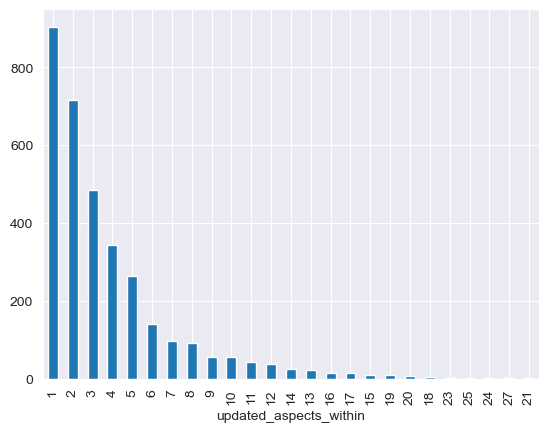

In [31]:
(
    totk_reviews_wa.updated_aspects_within.apply(lambda x: len(x))
                   .value_counts()
                   .plot.bar()
);

- Most review text contains between 1 and 5 aspects.
- There are still hundreds that contain more
- Let's take a look at the reviews containing more than 20

In [92]:
aspect_sentiment_df = pd.read_csv('TOTK_aspect_sentiment_counts.csv', index_col=0)

In [3]:
len(totk_reviews_wa)

3350

In the beginning I decided to group certain aspects under certain umbrella categories.

Below is a list of tuples with three values:
1. A list of aspects
2. An integer
3. String

These will be used in the function tht creates the plot as 3 is a title of the plot, the number is the axes indexer and the list of aspects are the aspects whose counts will be plotted.

In [27]:
aggregated_aspects = [(["Framerate","Graphics","Visuals", "Soundtrack"],0, "Presentation"),
                      (["Combat","Weapons","Fuse","Weapon Durability", "Bosses","Enemies","Final Boss"],1, "Combat"),
                      (["Puzzles","Shrines","Dungeons"],2, "Puzzles and Dungeons"),
                      (["Plot","Characters","Main Quests"],3, "Main Story and Quests"), 
                      (["Ability","Fuse","Ultrahand","Recall","Ascend","AutoBuild", "Build","Vehicles"],4, "Abilities"),
                      (["Quests","SideQuests", "Side Adventures"],5, "SideQuests and Side Adventures"),
                      (["World","Sky", "Depths", "Exploration", "Caves"],6, "World and Exploration"),
                      (["Mechanics", "Gameplay","User Interface","Price"],7, "Miscellaneous"),
                      ]

In [145]:


def sentiment_proportions(df_,df2_,elem, num, title):


    #Plots the count of apsect mentions in each review category
    (df2_.explode('updated_aspects_within')
    .query('updated_aspects_within.isin(@elem)')
    .groupby(['updated_aspects_within','review_sentiment'])['review_sentiment']
    .count()
    .unstack()
    .plot.bar(ax = ax[num,1], title='Frequency of Mentions in Review Categories', rot = 0.75)
    )
    ax[num,1].set_xlabel('', rotation=0)
    #retrieves the y tick values for the plot
    yticks_mentions = ax[num, 1].get_yticks()
    
    ax[num, 1].set_yticks(yticks_mentions)

    
    #Plots bar chart of the aspects showing the proportions of negative positive and neutral repsonses.

    data_neg = (
    aspect_sentiment_df.set_index('Aspect')
    .query('Aspect.isin(@elem)')['Negative']
    .plot.bar(ax=ax[num,0],color='firebrick',label='Negative Sentiments',title=title, rot=0.75)
    )
    data_pos = (
        aspect_sentiment_df.set_index('Aspect')
        .query('Aspect.isin(@elem)')['Positive']
        .plot.bar(ax=ax[num,0],color='lightblue',position=-0.15,label='Positive Sentiments')
    )
    data_neu = (
        aspect_sentiment_df.set_index('Aspect')
        .query('Aspect.isin(@elem)')['Neutral']
        .plot.bar(ax=ax[num,0],color='orange',position=0.15,label='Neutral Sentiments')
    )
    ax[num,0].legend(loc='best')
    ax[num, 0].set_yticks(yticks_mentions)
    ax[num,1].set_ylabel('', rotation=0)
    
    
    
    

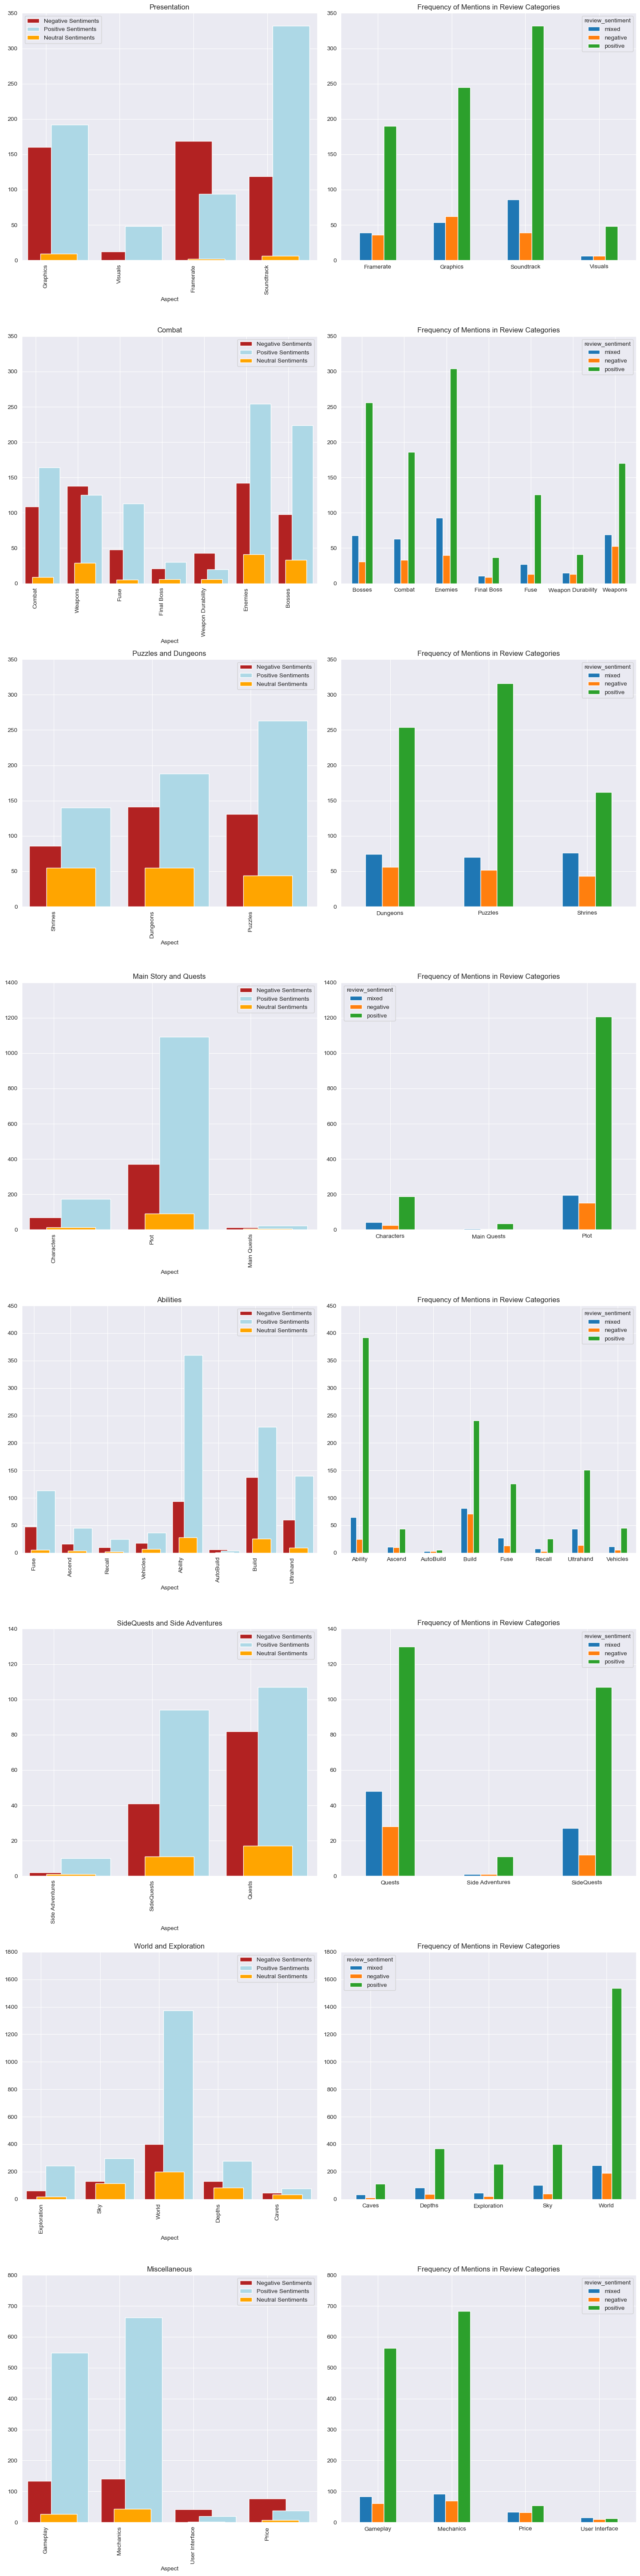

In [146]:
fig, ax = plt.subplots(8,2, figsize=(15,60))

for elem, i, title in aggregated_aspects:
    
    sentiment_proportions(aspect_sentiment_df,totk_reviews_wa, elem, i, title)

    

plt.tight_layout();

# Identifying Aspects That Could Improve.
Above we have 2 plots for each group of aspects. The bar plot on the left show the count of sentiment classifications for each aspect while the one on the right displays the number of times each aspect appeared in a review with a positive, negative or mixed score. In this way we can get an indication of what players are willing to praise or critique even if the overall sentiment of the review is very different. 

### Presentation
- Framerate is an obvious point of major criticism and the chief issue players seem to have with the game. 
- Almost all aspects are mentioned more in positive reviews than mixed or negative despite this. We can see that framerate and graphics have a lot of negative sentiments.
- There are positive reviews that negatively discuss the games graphics. It's a sign that this is an area that needs to be improved in future.


### Combat
- "Weapons" is a vague aspect that ecompasses the word "weapons" an "weapons sytem". Weapons system itself would include durability and the fuse mechanic. Whilst we can't decipher the why the data shows that it is an aspect that is talked of more negatively than positively. 
- "Weapon Durability" is a returning feature from the previous game and has around the same negative sentiments as overall mentions in positive reviews. Indicating its a strongly disliked mechanicm with the implication that even positive user reviews address it as a point of criticism.
- The weapon system could benefit from a reconfiguration in future installments.
- The fuse ability however was well recieved so perhaps a variation could return in future. 

### Puzzles and Dungeons
- Mainly positive/neutral sentiments. Overall positive and a deeper analysis would be required to understand what needed to be improved.

### Main Story and Quests
- Great praise toward the plot ( I am personally confused)
- The realist of "Main Quests" as an aspect is that during a main quest players will play in dungeons and unravel more of the games story/plot. Those two recieve positive sentiments so while they are explicitly mentioned here we can also see its a niche aspect to talk about and we can assume players were overall happy with this games main missions and story.

### Abilities
- Across the board we see praise of the abilities in this game.
- "Ability" is an umbrella term used for the ability game mechanics and players responded more positively toward these overall.
- "Autobuild" is the only ability with an overall negative sentiment proportion. However it is extremely niche and is ultimately a sub-feature of the "Build" category as is "UltraHand". Constructing physics objects is a large part of the games core gameplay loop and ultra hand and autobuild help facilitate this feauture.
- "Build" and "UltraHand" are ultimately praised. 

### SideQuests and Side Adventures
- "Quests", like "Ability" is an encompassing term. 
- "Quests" recieves mixed reaction, and is mentioned in reviews of all sentiments.
- "Side Adventures" are more in depth quests involving main characters and provide more meaningful in-game reward for players. While it's mentioned by few users, there's evidently a majority consesus that these type of quests are a good feature. Future installments could use side adventures as a template for a majority of quests present in the game.

### World and Exploration
- "World" is mentioned ~2000 times and has an overwhelmingly majority positive response.
- "Exploration" is mentioned only ~1/10th of the times "world" is referenced, however has a overwhelmigly positive response.
- The rest of the categories, maintain narrow margins between sentiment counts  with plenty of responses remaining neutral and negative despite overall positive repsonses.

### Miscellaneous 
- "Mechanics" and "Gameplay" are vague sentiments that describe almost every interactable element of a videogame. The overall majority positive response really just suggests that most players like many aspects of the game. 
-
- There is a lot of negative snetiment toward the games UI. Despite being a niche category it's important to consider that UI is probably an area that should be improved in future installments
- The negative sentiment toward the Price is self-explanatory. However it is niche and frankly many players are unlikely to say "worth the price" in their review of a videogame. 

### What Can We Learn _About_ User Reviews
- We can see that a majority of user reviews simply arent that detailed.
- ~2000 reviews do not mention any aspect at all

*Caveat is that my list of aspects is most definitely not complete.

------
When it comes to user reviews we have to acknowlege a few things:
1. Users have spent money on their games. Professional Critics are sent review copies. (sunk cost bias)
2. Users may post their reviews after months of time experiencing it. Pro critics have a shorter deadline.
3. There tends to be more brevity from user reviews. Meaning that players may fixate on one or two aspects of a game to talk about rather than the game as a whole
4. Mixed and Negative reviews are more likely to be detailed and to explain and therefore mention an aspect and their reason or its sentiment.
5. Not all users may recognise or be able to articulate areas of discontent.

-------